# Simple Calculator Clone in GPT
------
1. Train the GPT on your own dataset of choice! What other data could be fun to blabber on about?
    - A fun advanced suggestion if you like: train a GPT to do addition of two numbers, i.e. `a+b=c`. You may find it helpful to predict the digits of `c` in reverse order, as the typical addition algorithm (that you're hoping it learns) would proceed right to left too. You may want to modify the data loader to simply serve random problems and skip the generation of `train.bin`, `val.bin`. You may want to mask out the loss at the input positions of `a+b` that just specify the problem using `y=-1` in the targets (see `CrossEntropyLoss :ignore_index`.
    - Does your Transformer learn to add? Once you have this: build a calculator clone in GPT, for all of `+-*/`. _Not an easy problem. You may need Chain of Thought traces_.)


-----
>Let's focus on building a simple calculator clone in GPT that performs these mathematical operations: `+-*/`.
----

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math, re
import random
from tqdm import tqdm
import csv, os
import matplotlib.pyplot as plt


import time
import timeit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.nn.parallel import DataParallel


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

-------
## 1. GPT Model
------

In [2]:
#-------------------------------------------------------------------------------------------------------------------------
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        
        self.n_head = n_head                                                     # nh
        self.n_embd = n_embd
        self.head_size = n_embd // n_head                                        # hs
        self.scale = self.head_size ** -0.5
        
        assert n_embd % n_head == 0
        assert self.head_size * n_head == n_embd, "embed_dim must be divisible by num_heads"

        # key, query, value projections for all heads, but in a batch & output projection
        self.qkv_proj = nn.Linear(n_embd, 3 * n_embd, bias=bias)
        self.out_proj = nn.Linear(n_embd, n_embd, bias=bias)

        # regularization: dropout
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
#         self.dropout = nn.Dropout(dropout)

        # mask for self-attention
        self.register_buffer("mask", torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size))
        #self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        qkv = self.qkv_proj(x)
        qkv = qkv.view(B, T, self.n_head, 3 * self.head_size)

        # splits the qkv tensor into three tensors along the last dimension to get Q, K, V tensors
        q, k, v = qkv.chunk(3, dim=-1)                                           # (B, T, nh, hs)
        q = q.transpose(1, 2)                                                    # (B, nh, T, hs)
        k = k.transpose(1, 2)                                                    # (B, nh, T, hs)
        v = v.transpose(1, 2)                                                    # (B, nh, T, hs)

        # compute attention weights ('affinities')
        # self.scale = 1.0 / math.sqrt(k.size(-1))
        att_w = (q @ k.transpose(-2, -1)) * self.scale                           # (B, nh, T, hs) @ (B, nh, hs, T) -> (B, nh, T, T)
        att_w = att_w.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))   # (B, nh, T, T)
        att_w = F.softmax(att_w, dim=-1)                                         # (B, nh, T, T)
        att_w = self.attn_dropout(att_w)                                              # (B, nh, T, T)

        attn_output = att_w @ v                                                   # (B, nh, T, T) @ (B, nh, T, hs) -> (B, nh, T, hs)

        # re-assemble all head outputs side by side & final output projection
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, C)      # (B, T, n_embd)
        out_proj = self.resid_dropout(self.out_proj(attn_output))                 # (B, T, n_embd)
        return out_proj

class FeedFoward(nn.Module):
    """ a feedforward MLP"""

    def __init__(self, n_embd, activation_fn='relu'):
        super().__init__()
        self.in_proj = nn.Linear(n_embd, 4 * n_embd, bias=bias)   # fully connected
        self.activation_fn = activation_fn
        self.gelu = nn.GELU() # NewGELU()
        self.relu = nn.ReLU()
        self.out_proj = nn.Linear(4 * n_embd, n_embd, bias=bias)  # projection
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.in_proj(x)
        if self.activation_fn == 'relu':
            x = self.relu(x)
        elif self.activation_fn == 'gelu':
            x = self.gelu(x)
        x = self.out_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(self, n_embd, n_head, activation_fn='relu'):
        super().__init__()
        self.ln1 = LayerNorm(n_embd, bias=bias)              # nn.LayerNorm(n_embd)
        self.attn = MultiHeadSelfAttention(n_embd, n_head)
        self.ln2 = LayerNorm(n_embd, bias=bias)              # nn.LayerNorm(n_embd)
        self.ffwd = FeedFoward(n_embd, activation_fn=activation_fn)

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x


class GPT(nn.Module):
    def __init__(self, activation_fn='gelu'):
        super().__init__()
        assert vocab_size is not None
        assert block_size is not None
        assert n_layer is not None
        assert n_head is not None
        assert n_embd is not None
        
        self.activation_fn = activation_fn
        self.ndigit = ndigit
        self.block_size = block_size
        self.vocab_size = vocab_size

        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head, activation_fn=activation_fn) for _ in range(n_layer)])
        self.ln_f = LayerNorm(n_embd, bias=bias)   # nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size, bias=False)
        self.dropout = nn.Dropout(dropout)

        self.num_parameters = self.get_num_params()
        print("number of parameters: %.2fM" % (self.num_parameters/1e6,))

        self.apply(self._init_weights)   # init all the weights
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('out_proj.weight'):
                if self.activation_fn == 'gelu':
                    nn.init.xavier_uniform_(p, gain=1.0)  # GELU has a gain of 1.0
                elif self.activation_fn =='relu':
                    nn.init.kaiming_normal_(p, a=0, mode='fan_in', nonlinearity='relu')
                else:
                    raise ValueError(f"Unsupported activation function: {self.activation_fn}")
                    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.Embedding):
            if self.activation_fn == 'gelu':
                nn.init.xavier_uniform_(module.weight, gain=1.0)  # GELU has a gain of 1.0
            elif self.activation_fn =='relu':
                nn.init.kaiming_uniform_(module.weight, a=0, mode='fan_in', nonlinearity='relu')
            else:
                raise ValueError(f"Unsupported activation function: {self.activation_fn}")
            if isinstance(module, nn.Linear) and module.bias is not None:
                nn.init.zeros_(module.bias)

    def get_num_params(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def forward(self, idx, targets=None):
        device = idx.device
        B, T = idx.shape
        assert T <= block_size, f"Cannot forward sequence of length {T}, block size is only {block_size}"
        pos = torch.arange(T, dtype=torch.long, device=device).unsqueeze(0)       # (1,T)
        
        # idx and targets are both (B,T) tensor of integers [C = n_embd]
        tok_emb = self.token_embedding_table(idx)                                 # (B,T,C)
        pos_emb = self.position_embedding_table(pos)                              # (T,C)
        x = tok_emb + pos_emb                                                     # (B,T,C)
        x = self.dropout(x)
        x = self.blocks(x)                                                        # (B,T,C)
        x = self.ln_f(x)                                                          # (B,T,C)
        logits = self.lm_head(x)                                                  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)

        return logits, loss
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, do_sample=True, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context (idx) is growing too long we must crop it at block_size
            idx_len = idx.size(1)                                  # get length of idx, T, from idx shape (B, T)
            idx_cut = idx[:, -block_size:]                         # crop idx to the last block_size tokens
            idx_cond = idx if idx_len <= block_size else idx_cut   # crop idx to the last block_size tokens if it exceeds block_size
            logits, loss = self(idx_cond)                          # get the predictions
            logits = logits[:, -1, :] / temperature                # (B, C) pluck the logits of the last time step and scale by temp.
            if top_k is not None:                                  # if top_k is specified, the logits are filtered to keep only the top k values.
                top_k = min(top_k, logits.size(-1))                # ensures top_k does not exceed the number of logits.
                top_v, _ = torch.topk(logits, top_k)               # selects the top k logits
                logits[logits < top_v[:, [-1]]] = -float('Inf')    # sets all logits that are not in the top k to -inf,
            probs = F.softmax(logits, dim=-1)                      # (B, C) - apply softmax to turn logits to probabilities
            if do_sample:                                          # either sample from the distribution or take the most likely element
                idx_next = torch.multinomial(probs, num_samples=1) # (B, 1) - sample next token from the prob. distribution
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)       # (B, 1) - take the most likely token if not sampling
            idx = torch.cat((idx, idx_next), dim=1)                # (B, T+1) - append sampled index to the running sequence
        return idx    
    


------
## 2. Function for Model Training
------

In [3]:
def train_calculator_model(model, train_loader, val_loader, optimizer,
                           ndigit, device, 
                           max_epochs, eval_iters, eval_interval) -> tuple:
    
    def get_batch(loader):
        x, y, _ = next(iter(loader))
        return x.to(device), y.to(device)

    def estimate_loss():
        out = {}
        model.eval()
        for split in ['train', 'val']:
            loader = train_loader if split == 'train' else val_loader
            losses = torch.zeros(min(eval_iters, len(loader)))
            for k in range(min(eval_iters, len(loader))):
                X, Y = get_batch(loader)
                with torch.no_grad():
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
        model.train()
        return out

    train_losses = []
    val_losses = []
    val_accuracy_list = []
    val_mae_list = []
    epochs_list = []
    total_iters = max_epochs * len(train_loader)

    for iteration in range(total_iters + 1):
        # Train step
        x, y, _ = next(iter(train_loader))
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits, loss = model(x, y)
        loss.backward()
        optimizer.step()

        # Evaluate loss periodically
        if iteration % eval_interval == 0:
            losses = estimate_loss()
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])
            
            # Calculate epoch
            epoch = (iteration // len(train_loader))
            epochs_list.append(epoch)
            
            # Calculate validation accuracy and MAE
            model.eval()
            correct = 0
            total = 0
            total_mae = 0
            with torch.no_grad():
                for x, y, _ in val_loader:
                    x, y = x.to(device), y.to(device)
                    logits, _ = model(x, y)
                    y_pred = logits[:, -ndigit-6:, :].argmax(dim=-1)
                    y_true = y[:, -ndigit-6:]
                    correct += (y_pred == y_true).all(dim=1).sum().item()
                    total += y_true.shape[0]
                    
                    # Improved MAE calculation
                    for i in range(y_true.shape[0]):
                        num_digits = (y_true[i] != -1).sum().item()  # Assuming -1 is the padding value
                        if num_digits > 0:
                            total_mae += torch.abs(y_pred[i, :num_digits] - y_true[i, :num_digits]).sum().item() / num_digits

            val_accuracy = correct / total * 100
            val_accuracy_list.append(val_accuracy)
            val_mae = total_mae / total
            val_mae_list.append(val_mae)

            if epoch % (max_epochs // 10) == 0:
                print(f"Epoch: {epoch:>3} / {max_epochs:<6} "
                      f"Iter: {iteration:>5} / {total_iters:<8} "
                      f"Train Loss: {losses['train']:<9.4f} "
                      f"Validation Loss: {losses['val']:<9.4f} "
                      f"Validation Accuracy: {val_accuracy:<4.2f}% "
                      f"Validation MAE: {val_mae:<8.4f}")

    return model, epochs_list, train_losses, val_losses, val_accuracy_list, val_mae_list

-----
## 3. Functions for Model Evaluation
------

In [4]:
def list_to_number(lst):
    # Convert tokens to characters
    char_list = [str(d) if isinstance(d, int) else d for d in lst]

    # Join the characters into a string
    num_str = ''.join(char_list)

    # Remove leading zeros
    num_str = num_str.lstrip('0')

    # If the string is empty after removing zeros, it was zero
    if not num_str:
        return 0

    # Check for multiple occurrences of '-'
    if num_str.count('-') >= 1:
        # Find the position of the last '-'
        last_neg_pos = num_str.rfind('-')
        # Extract the substring from the last '-' to the end
        num_str = num_str[last_neg_pos:]

    # Handle multiple decimal points
    decimal_points = num_str.count('.')
    if decimal_points > 1:
        parts = num_str.split('.')
        # Keep the first part and the first decimal point
        num_str = parts[0] + '.' + ''.join(parts[1:])

    # If the string is empty after removing minus signs, it was just a minus sign
    if not num_str:
        return 0

    # Convert the string to a float or integer
    try:
        if '.' in num_str:
            return float(num_str)
        else:
            return int(num_str)
    except ValueError:
        # If conversion fails, return 0 or handle the error as needed
        print(f"Warning: Could not convert '{num_str}' to a number.")# Returning 0.")
        # return 0

def decode_data(x, y, op) -> str:
    operators = ['+', '-', '*', '/', '.']
    a = ''.join(map(str, x[:ndigit].tolist()))
#         op = operators[x[ndigit].item() - 10]
    b = ''.join(map(str, x[ndigit+1:2*ndigit+1].tolist()))
    c = ''.join(map(lambda t: str(t) if t < 10 else operators[t-10], y[2*ndigit:].tolist()))[::-1]
    return f"{a} {op} {b} = {c}"

In [5]:
def char_to_token(char):
    tokens = {'+': 10, '-': 11, '*': 12, '/': 13, '.': 14}
    return tokens.get(char, char)

def token_to_char(token):
    chars = {10: '+', 11: '-', 12: '*', 13: '/', 14: '.'}
    return chars.get(token, str(token))

def eval_calculator(model, ndigit, device, num_tests=1000) -> float:
    model.eval()
    correct = 0
    incorrect = 0
    for _ in range(num_tests):
        a = random.randint(0, 10**ndigit - 1)
        b = random.randint(1, 10**ndigit - 1)  # Ensure b is not zero for division
        op = random.choice(['+', '-', '*', '/'])

        problem = f"{a:0{ndigit}d}{op}{b:0{ndigit}d}"
#         print(f"{problem} = ?")
        context = torch.tensor([int(d) if d.isdigit() else char_to_token(d) for d in problem], dtype=torch.long).unsqueeze(0).to(device)

        with torch.no_grad():
            generated = model.generate(context, max_new_tokens=ndigit+6, temperature=0.8)

        predicted = list_to_number([str(d.item()) if d.item() < 10 else token_to_char(d.item()) for d in generated[:, -ndigit-6:].flip(1)[0]])

        if op == '+':
            actual = a + b
        elif op == '-':
            actual = a - b
        elif op == '*':
            actual = a * b
        elif op == '/':
            actual = a / b

        if op == '/':
            if abs(predicted - actual) < 1e-5:
                correct += 1
        else:
            if predicted == actual:
                correct += 1

    accuracy = correct / num_tests * 100
    print(f"\nFinal score: {correct}/{num_tests} = {accuracy:.2f}% Accuracy\n")
    return accuracy

def eval_calculator2(model, ndigit, device, num_tests=1000, num_to_see=10) -> float:
    model.eval()
    correct = 0
    incorrect = 0
    incorrect_examples_printed = 0
    correct_examples_printed = 0

    def generate_input(a, b, op):
        astr = f'{a:0{ndigit}d}'
        bstr = f'{b:0{ndigit}d}'
        render = astr + op + bstr
        dix = [int(s) if s.isdigit() else char_to_token(s) for s in render]
        return torch.tensor(dix, dtype=torch.long).unsqueeze(0).to(device)

    def char_to_token(char):
        tokens = {'+': 10, '-': 11, '*': 12, '/': 13, '.': 14}
        return tokens.get(char, char)

    def token_to_char(token):
        chars = {10: '+', 11: '-', 12: '*', 13: '/', 14: '.'}
        return chars.get(token, str(token))

    max_value = 10 ** ndigit - 1
    operations = ['+', '-', '*', '/']

    for _ in range(num_tests):
        a = random.randint(0, max_value)
        b = random.randint(1, max_value)  # Avoid zero for division
        op = random.choice(operations)


        problem = f"{a:0{ndigit}d}{op}{b:0{ndigit}d}"
        x2 = torch.tensor([int(d) if d.isdigit() else char_to_token(d) for d in problem], dtype=torch.long).unsqueeze(0).to(device)

        with torch.no_grad():
            generated = model.generate(x2, max_new_tokens=ndigit+6, temperature=0.8)
        predicted = list_to_number([str(d.item()) if d.item() < 10 else token_to_char(d.item()) for d in generated[:, -ndigit-6:].flip(1)[0]])

        # Calculate expected result
        if op == '+':
            expected = a + b
        elif op == '-':
            expected = a - b
        elif op == '*':
            expected = a * b
        elif op == '/':
            expected = a / b

#         print(f"Expected: {expected}")
#         print()

        if op == '/':
            if abs(predicted - expected) < 1e-5:
                correct += 1
            correct_bool = (abs(predicted - expected) < 1e-5)
        else:
            if predicted == expected:
                correct += 1
            correct_bool = (predicted == expected)

        if correct_bool and correct_examples_printed < num_to_see:
            correct_examples_printed += 1
            print(f"Correct: {a} {op} {b} = {predicted}, Actual: {expected}")
        if not correct_bool and incorrect_examples_printed < num_to_see:
            incorrect_examples_printed += 1
            print(f"Incorrect: {a} {op} {b} = {predicted}, Actual: {expected}")

    accuracy = correct / num_tests * 100
    print(f"\nFinal score: {correct}/{num_tests} = {accuracy:.2f}% Accuracy\n")

    return accuracy

In [6]:
def evaluate(predictions, true_values):
    predictions = np.array(predictions)
    true_values = np.array(true_values)

    # Calculate accuracy
    exact_matches = np.sum(np.all(np.abs(predictions - true_values) == 0, axis=1))
    accuracy = exact_matches / len(true_values) * 100

    # Calculate MAE
    mae = np.mean(np.abs(predictions - true_values).astype(np.float64))

    # Calculate MSE
    mse = np.mean((predictions - true_values) ** 2)

    # Calculate RMSE
    rmse = np.sqrt(mse)

    return {
        'accuracy (%)': accuracy,
        'mae': mae,
        'mse': mse,
        'rmse': rmse
    }

-----
## 4. Functions for Plotting Losses & Validation Metrics (Accuracy, MAE)
------

In [7]:
def plot_losses(epochs_completed, train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_completed, train_losses, label='Training Loss')
    plt.plot(epochs_completed, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
def plot_losses2(epochs_list, train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    for i, loss in enumerate(train_losses):
        if i % 10 == 0:
            plt.plot(epochs_list[i], loss, marker='o', label=f'Epoch {epochs_list[i]}')
    plt.plot(epochs_list[::10], train_losses[::10], label='Training Loss')
    plt.plot(epochs_list[::10], val_losses[::10], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
    
#--------------------------------------------------------------------------------------------------------------------------------

def plot_validation_metrics(epochs_completed, val_accuracy_list, val_mae_list):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Validation Accuracy (%)', color=color)
    ax1.plot(epochs_completed, val_accuracy_list, color=color, label='Validation Accuracy')
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Validation MAE', color=color)  # We already handled the x-label with ax1
    ax2.plot(epochs_completed, val_mae_list, color=color, label='Validation MAE')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # Otherwise the right y-label is slightly clipped
    plt.title('Validation Metrics')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.show()
    
    
def plot_accuracy(epochs_completed, val_accuracy_list):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_completed, val_accuracy_list)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy')
    plt.tight_layout()
    plt.show()                                              # Display the plot

def plot_mae(epochs_completed, val_mae_list):
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_completed, val_mae_list)
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.title('Validation MAE')
    plt.tight_layout()
    plt.show()   

---------
## 5. Data Preparation
----------

In [8]:
class CalculatorDataset(Dataset):
    """
    A dataset class for a calculator that generates examples of mathematical operations.

    Args:
    ndigit (int): The number of digits in the numbers to be operated on.
    split (str): The split of the dataset to use. Can be 'train', 'val', or 'test'.
    rng_num (int, optional): The seed to use for the random number generator. Defaults to 1337.

    Attributes:
    ndigit (int): The number of digits in the numbers to be operated on.
    split (str): The split of the dataset to use.
    operators (list): A list of the operators to use.
    max_result_length (int): The maximum length of the result.
    ixes (torch.Tensor): A tensor of indices for the dataset.
    """

    def __init__(self, ndigit: int, split: str, rng_num: int = 1337) -> None:
        """
        Initializes the CalculatorDataset.

        Args:
        ndigit (int): The number of digits in the numbers to be operated on.
        split (str): The split of the dataset to use.
        rng_num (int, optional): The seed to use for the random number generator. Defaults to 1337.
        """
        self.ndigit = ndigit
        self.split = split
        self.operators = ['+', '-', '*', '/']
        self.max_result_length = ndigit + 1 + 6  # Max integer part + decimal point + 6 decimal places

        # Total number of possible calculation problems
        num_add_sub_mul = 3 * (10**(2 * ndigit))
        num_div = 10**(2 * ndigit) - 10**ndigit
        num = num_add_sub_mul + num_div

        rng = torch.Generator()
        rng.manual_seed(rng_num)
        perm = torch.randperm(num, generator=rng)  # Random permutation of all possible indices

        # Define the sizes of train, validation, and test splits
        num_val = int(num * 0.05)  # Validation set size
        num_test = int(num * 0.05)  # Test set size
        num_train = num - num_val - num_test  # Training set size

        if split == 'train':
            self.ixes = perm[:num_train]
        elif split == 'val':
            self.ixes = perm[num_train:num_train + num_val]
        elif split == 'test':
            self.ixes = perm[num_train + num_val:num_train + num_val + num_test]
        else:
            raise ValueError("Split must be 'train', 'val', or 'test'")

    def __len__(self) -> int:
        """
        Returns the number of examples in the dataset.

        Returns:
        int: The number of examples in the dataset.
        """
        return self.ixes.nelement()  # Number of examples

    def __getitem__(self, idx: int) -> tuple:
        """
        Returns an example from the dataset.

        Args:
        idx (int): The index of the example to return.

        Returns:
        tuple: A tuple containing the input, output, and operator of the example.
        """
        idx = self.ixes[idx].item()  # Get the index
        nd = 10**self.ndigit

        # Determine which operation and decode the index
        if idx < (3 * nd * nd):
            op_idx = idx // (nd * nd)
            op = self.operators[op_idx]
            rem = idx % (nd * nd)
            a = rem // nd
            b = rem % nd
        else:
            op = '/'
            rem = idx - (3 * nd * nd)
            a = rem // (nd - 1)
            b = (rem % (nd - 1)) + 1

        return self.create_example(a, b, op)

    def create_example(self, a: int, b: int, op: str) -> tuple:
        """
        Creates an example of a mathematical operation.

        Args:
        a (int): The first number.
        b (int): The second number.
        op (str): The operator.

        Returns:
        tuple: A tuple containing the input, output, and operator of the example.
        """
        if op == '+':
            c = a + b
        elif op == '-':
            c = a - b
        elif op == '*':
            c = a * b
        elif op == '/':
            c = a / b

        astr = f'{a:0{self.ndigit}d}'
        bstr = f'{b:0{self.ndigit}d}'

        if op in ['+', '-', '*']:
            full_cstr = f'{int(c):0{self.ndigit+1}d}'[::-1]
        else:  # division
            full_cstr = f'{c:.6f}'[::-1]  # 6 decimal places, reversed

        cstr = full_cstr[:-1]  # Exclude the last digit of c
        cstr = cstr.ljust(self.max_result_length, '0')  # Pad cstr to max_result_length
        full_cstr_padded = full_cstr.ljust(self.max_result_length, '0')  # Pad full_cstr to max_result_length

        render = astr + op + bstr + cstr
        full_render = astr + op + bstr + full_cstr_padded
        dix = [int(s) if s.isdigit() else self.char_to_token(s) for s in render]
        full_dix = [int(s) if s.isdigit() else self.char_to_token(s) for s in full_render]

        # Exclude operators from x and mask positions corresponding to a and b in y

        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(full_dix[1:], dtype=torch.long)  # Use full_dix to make y shorter
        y[:self.ndigit * 2] = -1  # Mask positions corresponding to a and b and op

        return x, y, op

    def char_to_token(self, char: str) -> int:
        """
        Converts a character to a token.

        Args:
        char (str): The character to convert.

        Returns:
        int: The token corresponding to the character.
        """
        if char == '+':
            return 10
        elif char == '-':
            return 11
        elif char == '*':
            return 12
        elif char == '/':
            return 13
        elif char == '.':
            return 14

    def get_vocab_size(self) -> int:
        """
        Returns the size of the vocabulary.

        Returns:
        int: The size of the vocabulary.
        """
        return 15  # 0-9 digits, +, -, *, /,., =

    def get_block_size(self) -> int:
        """
        Returns the block size of the dataset.

        Returns:
        int: The block size of the dataset.
        """
        return 2 * self.ndigit + 1 + self.max_result_length - 1  # Two numbers, operator, and padded result (excluding last digit)

In [9]:
# Testing function for the CalculatorDataset

def check_calculator_dataset(ndigit=3):
    ndigit = ndigit
    rng_num = 42  # For reproducibility

    # Create datasets for each split
    train_dataset = CalculatorDataset(ndigit, split='train', rng_num=rng_num)
    val_dataset = CalculatorDataset(ndigit, split='val', rng_num=rng_num)
    test_dataset = CalculatorDataset(ndigit, split='test', rng_num=rng_num)

    # Check sizes
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")

    # Function to decode the data
    def decode_data(x, y, ndigit):
        operators = ['+', '-', '*', '/', '.']#, '=']
        a = ''.join(map(str, x[:ndigit].tolist()))
        oper = operators[x[ndigit].item() - 10]
        b = ''.join(map(str, x[ndigit+1:2*ndigit+1].tolist()))
        c = ''.join(map(lambda t: str(t) if t < 10 else operators[t-10], y[2*ndigit:].tolist()))[::-1]
        return f"{a} {oper} {b} = {c}"

    # Check a few examples from each dataset
    print("\nTrain dataset examples:")
    for i in range(1): #5
        x, y, op = train_dataset[i]
        print(decode_data(x, y, ndigit))
        print(f"x: {x}")
        print(f"y: {y}")
        print(f"Masked positions in y: {(y == -1).sum().item()}\n")


    print("\nValidation dataset examples:")
    for i in range(1): #3
        x, y, op = val_dataset[i]
        print(decode_data(x, y, ndigit))
        print(f"x: {x}")
        print(f"y: {y}")
        print(f"Masked positions in y: {(y == -1).sum().item()}\n")


    print("\nTest dataset examples:")
    for i in range(1): #3
        x, y, op = test_dataset[i]
        print(decode_data(x, y, ndigit))
        print(f"x: {x}")
        print(f"y: {y}")
        print(f"Masked positions in y: {(y == -1).sum().item()}\n")


    # Test with DataLoader
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    batch = next(iter(train_loader))
    print(f"\nBatch shape from DataLoader: {batch[0].shape}, {batch[1].shape}")

    # Check vocab size and block size
    print(f"\nVocab size: {train_dataset.get_vocab_size()}")
    print(f"Block size: {train_dataset.get_block_size()}")

if __name__ == "__main__":
    check_calculator_dataset(2)

Train dataset size: 35910
Validation dataset size: 1995
Test dataset size: 1995

Train dataset examples:
91 * 42 = 000003822
x: tensor([ 9,  1, 12,  4,  2,  2,  2,  8,  0,  0,  0,  0,  0])
y: tensor([-1, -1, -1, -1,  2,  2,  8,  3,  0,  0,  0,  0,  0])
Masked positions in y: 4


Validation dataset examples:
27 / 29 = 00.931034
x: tensor([ 2,  7, 13,  2,  9,  4,  3,  0,  1,  3,  9, 14,  0])
y: tensor([-1, -1, -1, -1,  4,  3,  0,  1,  3,  9, 14,  0,  0])
Masked positions in y: 4


Test dataset examples:
65 * 53 = 000003445
x: tensor([ 6,  5, 12,  5,  3,  5,  4,  4,  0,  0,  0,  0,  0])
y: tensor([-1, -1, -1, -1,  5,  4,  4,  3,  0,  0,  0,  0,  0])
Masked positions in y: 4


Batch shape from DataLoader: torch.Size([32, 13]), torch.Size([32, 13])

Vocab size: 15
Block size: 13


----
Let's implement and train a GPT model to do simple calculation between two numbers,`a+b=c`.

### Expected loss in making a prediction, assuming a uniform distribution, is:
$$-ln(\frac{1}{vocab\_size})=-ln(\frac{1}{15})=2.7081$$ <br>

In the vocabulary, the digits are represented as `0123456789`, the mathematical operators are represented as `+-*/`, and for decimal point outputs we need `.` when we perform division. In total, that constitutes $\textbf{15}$ characters in the vocabulary. So, this should guide us in terms of a reasonable starting point for loss. Loss values that are **_much greater than_** $\boldsymbol{2.7081}$ signify that there is an issue/bug within our model.

----

In [10]:
print(f"The expected loss assuming a uniform distribution and no deep learning: {-np.log(1/15):.4f}")

The expected loss assuming a uniform distribution and no deep learning: 2.7081


-----
## 6. Specify Hyperparameters & Create Datasets for Training, Validation and Testing
------

Here are the some possible revised configurations that ensure `n_embd % n_head == 0`:

* `n_layer = 4`, `n_head = 8`, `n_embd = 256` (256 is divisible by 8)
* `n_layer = 4`, `n_head = 6`, `n_embd = 384` (384 is divisible by 6)
* `n_layer = 4`, `n_head = 12`, `n_embd = 384` (384 is divisible by 12)
* `n_layer = 4`, `n_head = 8`, `n_embd = 512` (512 is divisible by 8)

Note that I've adjusted the value of `n_embd` to ensure that it is divisible by `n_head` in each configuration.

In [11]:
# Assuming all the necessary classes and functions are defined above

# Hyperparameters
ndigit = 2
vocab_size = 15  # 0-9 digits, +, -, *, /, .
block_size = 3 * ndigit + 7

#----------------------tunable -----------------------------------------------------------------------------
n_layer = 6 #4
n_head = 8 #6
n_embd = 512 #384
learning_rate = 3e-5
batch_size = 64 #128
max_epochs = 100 
#----------------------------------------------------------------------------------------------------------

dropout = 0.1
bias = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create datasets and dataloaders
train_dataset = CalculatorDataset(ndigit, split='train')
val_dataset = CalculatorDataset(ndigit, split='val')
test_dataset = CalculatorDataset(ndigit, split='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
#----------------------------------------------------------------------------------------------------------

eval_iters = len(val_loader)
eval_interval = len(train_loader)
warm_up_steps = 1000
warm_up_lr = 3e-5

In [12]:
device, eval_iters, len(val_loader), len(train_loader), eval_interval, vocab_size, block_size

(device(type='cuda'), 32, 32, 562, 562, 15, 13)

In [13]:
torch.cuda.device_count()

1

-----
## 7. Initialize & Train the GPT Model to perform **2-digit calculations**: `ab+cd`, `ab-cd`, ...
------

In [14]:
%%time
# Initialize the model
model = GPT().to(device)
# if torch.cuda.device_count() > 1:
#     model = DataParallel(model)
model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
# scheduler = CosineAnnealingLR(optimizer, T_max=28100-2529, eta_min=3e-6)

model, epochs_list, train_losses, val_losses, val_accuracy_list, val_mae_list = train_calculator_model(
    model, train_loader, val_loader, optimizer,
    ndigit, device, max_epochs, eval_iters, eval_interval)

print(f"\nTraining completed after {epochs_list[-1]} epochs.")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Final validation accuracy: {val_accuracy_list[-1]:.2f}%")
print(f"Final validation MAE: {val_mae_list[-1]:.4f}")

number of parameters: 18.90M
Epoch:   0 / 100    Iter:     0 / 56200    Train Loss: 2.0970    Validation Loss: 2.1401    Validation Accuracy: 2.71% Validation MAE: 1.8788  
Epoch:  10 / 100    Iter:  5620 / 56200    Train Loss: 0.1826    Validation Loss: 0.3044    Validation Accuracy: 57.54% Validation MAE: 0.3205  
Epoch:  20 / 100    Iter: 11240 / 56200    Train Loss: 0.0748    Validation Loss: 0.3816    Validation Accuracy: 61.70% Validation MAE: 0.2801  
Epoch:  30 / 100    Iter: 16860 / 56200    Train Loss: 0.0315    Validation Loss: 0.5367    Validation Accuracy: 61.45% Validation MAE: 0.2823  
Epoch:  40 / 100    Iter: 22480 / 56200    Train Loss: 0.0153    Validation Loss: 0.5546    Validation Accuracy: 61.95% Validation MAE: 0.2887  
Epoch:  50 / 100    Iter: 28100 / 56200    Train Loss: 0.0155    Validation Loss: 0.6050    Validation Accuracy: 62.61% Validation MAE: 0.2723  
Epoch:  70 / 100    Iter: 39340 / 56200    Train Loss: 0.0049    Validation Loss: 0.6864    Validation

-----
## 8. Visualize the Loss & Accuracy Plots
------

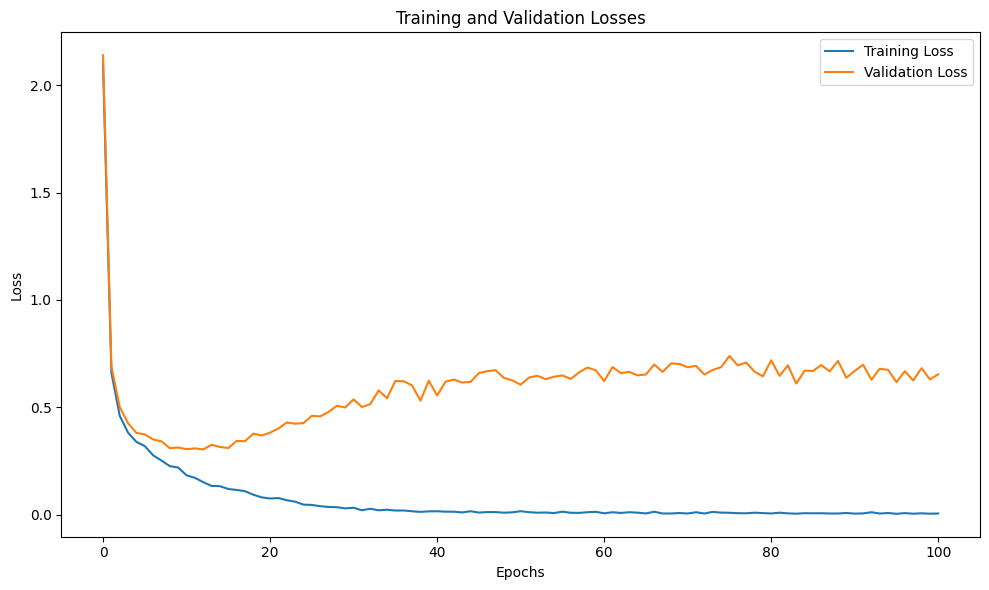

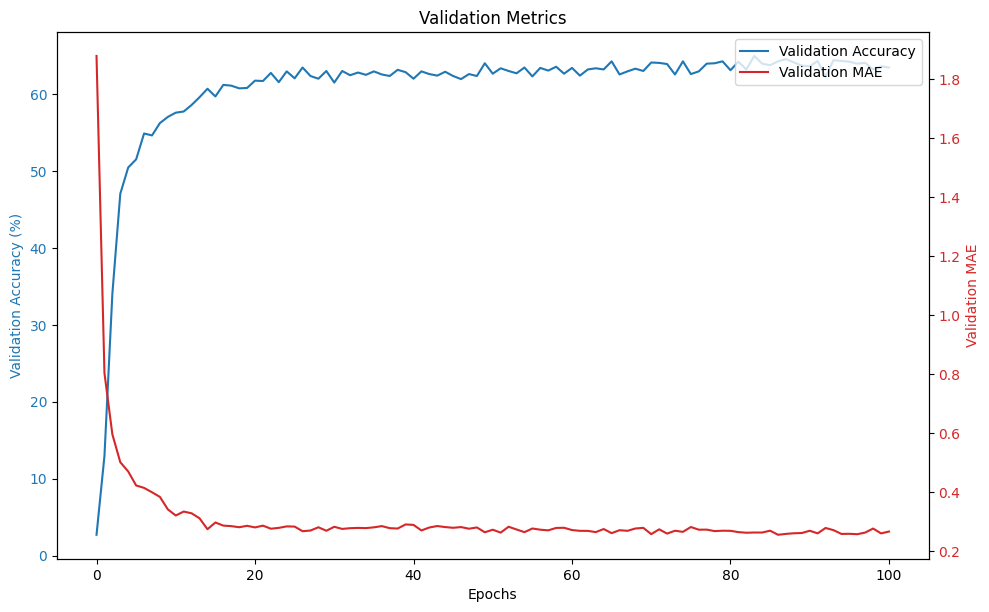

In [15]:
plot_losses(epochs_list, train_losses, val_losses)
# plot_accuracy(epochs_list, val_accuracy_list)
# plot_mae(epochs_list, val_mae_list)
plot_validation_metrics(epochs_list, val_accuracy_list, val_mae_list)

The **_Mean Absolute Error (MAE)_** is a measure of the average difference between the predicted values and the actual values. In this case, the MAE is calculated as the sum of the absolute differences between the predicted digits (`y_pred`) and the actual digits (`y_true`), divided by the total number of samples (`total`).

The scale range of MAE is typically between 0 and the maximum possible difference between the predicted and actual values. In my case, since I'm dealing with digits, the maximum possible difference is 9 (i.e., 9 - 0).

Here's a rough interpretation of the MAE values:

* **Low MAE values** (close to 0): Good! The model is accurately predicting the digits.
* **Medium MAE values** (around 1-3): Fair. The model is making some mistakes, but it's still doing relatively well.
* **High MAE values** (around 4-6): Bad. The model is making significant mistakes, and its predictions are not reliable.
* **Very high MAE values** (above 7): Very bad. The model is performing poorly, and its predictions are not trustworthy.

To give a better idea, here are some example MAE values and their corresponding accuracy levels:

* MAE = 0.1: 99% accuracy (i.e., the model is making almost no mistakes)
* MAE = 1.0: 90% accuracy (i.e., the model is making some mistakes, but it's still doing relatively well)
* MAE = 3.0: 70% accuracy (i.e., the model is making significant mistakes)
* MAE = 6.0: 40% accuracy (i.e., the model is performing poorly)

Keep in mind that these are rough estimates, and the actual accuracy levels may vary depending on the specific problem and dataset.

In this case, I can use the MAE value as a metric to evaluate the performance of my model. A lower MAE value indicates better performance, while a higher MAE value indicates worse performance. However, this approach does not account for target sequence length and as such is biased by length of the result sequences. To avoid this and ensure a more robust metric, I'll perform normalization to ensure a fair metric for sequences of varying lengths.

------------------------
<br><br>

The **Normalized Mean Absolute Error (NMAE)** is a measure of the average difference between the predicted values and the actual values, normalized by the number of digits in each sample (target sequence length). In this case, the NMAE is calculated as the sum of the absolute differences between the predicted digits (`y_pred`) and the actual digits (`y_true`), divided by the total number of samples (`total`) and number of digits in the target sequence. Normalizing MAE by the number of digits in each target sequence is essential for obtaining a meaningful measure of the model's performance. This normalization ensures that the MAE reflects the average error per digit, making it a meaningful metric regardless of the total number of samples or the length of the target sequences.

The scale range of NMAE is typically between 0 and 1, where:

* **Low NMAE values** (close to 0): Good! The model is accurately predicting the digits.
* **Medium NMAE values** (around 0.1-0.3): Fair. The model is making some mistakes, but it's still doing relatively well.
* **High NMAE values** (around 0.4-0.6): Bad. The model is making significant mistakes, and its predictions are not reliable.
* **Very high NMAE values** (above 0.7): Very bad. The model is performing poorly, and its predictions are not trustworthy.

To give a better idea, here are some example NMAE values and their corresponding accuracy levels:

* NMAE = 0.01: 99% accuracy (i.e., the model is making almost no mistakes)
* NMAE = 0.1: 90% accuracy (i.e., the model is making some mistakes, but it's still doing relatively well)
* NMAE = 0.3: 70% accuracy (i.e., the model is making significant mistakes)
* NMAE = 0.6: 40% accuracy (i.e., the model is performing poorly)

Keep in mind that these are rough estimates, and the actual accuracy levels may vary depending on the specific problem and dataset.

In this case, I can use the NMAE value as a metric to evaluate the performance of my model. A lower NMAE value indicates better performance, while a higher NMAE value indicates worse performance.

------------------------
<br><br>
In the context of evaluating the performance of a model, `mse` and `rmse` are two related metrics that measure the difference between the predicted values and the actual values.

* `mse` stands for **Mean Squared Error**, which is the average of the squared differences between the predicted values and the actual values. It's a measure of the average magnitude of the errors made by the model.
* `rmse` stands for **Root Mean Squared Error**, which is the square root of the mean squared error. It's a measure of the average magnitude of the errors made by the model, but it's more interpretable than `mse` because it's on the same scale as the original data.

In general, `mse` and `rmse` are used to evaluate the performance of a model in terms of its ability to predict continuous values. They're commonly used in regression problems, where the goal is to predict a continuous output variable.

Here are some key things to know about `mse` and `rmse`:

* A lower `mse` and `rmse` indicate better performance, because they indicate that the model is making smaller errors on average.
* `mse` is more sensitive to large errors than `rmse`, because it squares the errors before averaging them. This means that a few large errors can greatly increase the `mse`, even if the model is generally accurate.
* `rmse` is more interpretable than `mse`, because it's on the same scale as the original data. This makes it easier to understand the magnitude of the errors made by the model.

Since you're dealing with digits, the scale range for RMSE will depend on the maximum possible difference between the predicted and actual values.

In your case, since you're dealing with digits, the maximum possible difference is 9 (i.e., 9 - 0).

So, the scale range for MSE would be:

* **Low MSE values** (close to 0): Good! The model is accurately predicting the digits.
* **Medium MSE values** (around 1-3): Fair. The model is making some mistakes, but it's still doing relatively well.
* **High MSE values** (around 4-6): Bad. The model is making significant mistakes, and its predictions are not reliable.
* **Very high MSE values** (above 7): Very bad. The model is performing poorly, and its predictions are not trustworthy.

However, since RMSE is a square root of the mean squared error (MSE), the scale range will be slightly different. A good rule of thumb is to consider the following ranges:

* **Low RMSE values** (close to 0): Good! The model is accurately predicting the digits. (RMSE < 1)
* **Medium RMSE values** (around 1-2): Fair. The model is making some mistakes, but it's still doing relatively well. (1 ≤ RMSE < 2)
* **High RMSE values** (around 2-3): Bad. The model is making significant mistakes, and its predictions are not reliable. (2 ≤ RMSE < 3)
* **Very high RMSE values** (above 3): Very bad. The model is performing poorly, and its predictions are not trustworthy. (RMSE ≥ 3)

Keep in mind that these are rough estimates, and the actual scale range may vary depending on the specific problem and dataset.

In your case, the RMSE value of `1.0719` suggests that the model is making some mistakes, but it's still doing relatively well.

Overall, the `mse` and `rmse` values provide additional insight into the performance of your model, and can help you understand the magnitude of the errors it's making.

-----
## 9. Test the Model
------

In [16]:
%%time
# After training is complete, evaluate the model on the test dataset
#----------------------------------------------------------------------
# Assume test_loader, device, and model are already defined
test_loss = 0
test_correct = 0
test_total = 0
test_total_mae = 0

predictions = []
true_values = []

# Model evaluation mode
model.eval()

with torch.no_grad():
    for x, y, op in test_loader:
        x, y = x.to(device), y.to(device)
        logits, loss = model(x, y)
        test_loss += loss.item()
        
        # Assuming the target sequences are at the last positions and ndigit is defined
        y_pred = logits[:, -ndigit-6:, :].argmax(dim=-1)
        y_true = y[:, -ndigit-6:]
        
        test_correct += (y_pred == y_true).all(dim=1).sum().item()
        test_total += y_true.shape[0]
        
        # Calculate MAE considering the length of each sequence
        for i in range(y_true.shape[0]):
            num_digits = (y_true[i] != -1).sum().item()  # Assuming -1 is the padding value
            if num_digits > 0:
                test_total_mae += torch.abs(y_pred[i, :num_digits] - y_true[i, :num_digits]).sum().item() / num_digits
        
        # Collect predictions and true values for evaluation
        predictions.extend(y_pred.cpu().numpy().tolist())
        true_values.extend(y_true.cpu().numpy().tolist())

# Calculate average test loss and test accuracy
avg_test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / test_total * 100
avg_test_mae = test_total_mae / test_total

# Evaluate using the custom function
metrics = evaluate(predictions, true_values)
metrics = {key: round(value, 4) for key, value in metrics.items()}

print(f"No. of test samples: {test_total}")
print(f"Avg. Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Avg. Test MAE: {avg_test_mae:.4f}")
print(f"\nEvaluation Metrics: {metrics}")


No. of test samples: 1995
Avg. Test Loss: 0.6437
Test Accuracy: 66.87%
Avg. Test MAE: 0.2377

Evaluation Metrics: {'accuracy (%)': 66.8672, 'mae': 0.2377, 'mse': 1.149, 'rmse': 1.0719}
CPU times: user 600 ms, sys: 2 µs, total: 600 ms
Wall time: 598 ms


-----
## 10. Evaluate the Model on Unseen Data
------

In [17]:
%%time
with torch.no_grad():
    print("Generate new random calculations and measure test accuracy of generated calculations:")
    print('----------------------------------------------------')
    eval_calculator(model, ndigit, device, num_tests=1000)


Generate new random calculations and measure test accuracy of generated calculations:
----------------------------------------------------

Final score: 667/1000 = 66.70% Accuracy

CPU times: user 33.1 s, sys: 63 ms, total: 33.2 s
Wall time: 33.2 s


In [18]:
%%time
with torch.no_grad():
    print("Generate new random calculations and measure test accuracy of generated calculations (show some examples):")
    print('----------------------------------------------------\n')
    eval_calculator2(model, ndigit, device, num_tests=1000, num_to_see=5)

Generate new random calculations and measure test accuracy of generated calculations (show some examples):
----------------------------------------------------

Correct: 21 * 84 = 1764, Actual: 1764
Correct: 9 / 60 = 0.15, Actual: 0.15
Correct: 27 + 65 = 92, Actual: 92
Incorrect: 85 * 36 = 2.10302, Actual: 3060
Correct: 17 + 91 = 108, Actual: 108
Correct: 33 - 59 = -26, Actual: -26
Incorrect: 61 / 3 = 0.333333, Actual: 20.333333333333332
Incorrect: 68 + 89 = 5157, Actual: 157
Incorrect: 29 * 98 = 222842, Actual: 2842
Incorrect: 14 * 80 = 0.11112, Actual: 1120

Final score: 714/1000 = 71.40% Accuracy

CPU times: user 33.1 s, sys: 11 ms, total: 33.1 s
Wall time: 33.1 s


----
<br><br>
# Appendix
----
## A. Model Performance Log for Different Hyperparameter Combinations (`ndigit = 2`)

| S/o. | Layers | Heads | Embed. Dim. | Learn. rate | Batch Size | Epochs | Eval_iters | Eval_interval | Parameters (M) | Train loss | Val. loss | Val. Accuracy | Val. MAE | Test loss (avg) | Test Accuracy | Test MAE 
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- 
| A. | **6** | **8** | **512** | **6e-4** | **64** | 100 | **32** | **562** | 18.90 | 0.0331 | 0.4072 | 69.87% | - | 0.2665 | 65.61% | - 
| B. | **6** | **8** | **512** | **3e-5** | **64** | 100 | **32** | **562** | 18.90 | 0.0050 | 0.6533 | 63.41% | 0.2662 | 0.6437 | 66.87% | 0.2377 

----


In [19]:
# %%time
# # After training is complete, evaluate the model on the test dataset
# model.eval()
# test_loss = 0
# test_correct = 0
# test_total = 0
# test_total_mae = 0

# with torch.no_grad():
#     for x, y, op in test_loader:
#         x, y = x.to(device), y.to(device)
#         logits, loss = model(x, y)
#         test_loss += loss.item()
#         y_pred = logits[:, -ndigit-6:, :].argmax(dim=-1)
#         y_true = y[:, -ndigit-6:]
#         test_correct += (y_pred == y_true).all(dim=1).sum().item()
#         test_total += y_true.shape[0]
#         test_total_mae += torch.abs(y_pred - y_true).sum().item()

# # Calculate average test loss and test accuracy
# avg_test_loss = test_loss / len(test_loader)
# test_accuracy = test_correct / test_total * 100
# avg_test_mae = test_total_mae / test_total

# print(f"No. of test samples: {test_total} \nAvg. Test Loss: {avg_test_loss:.4f} \
#           \nTest Accuracy: {test_accuracy:.2f}% \nAvg. Test MAE: {avg_test_mae:.4f}")